In [1]:
!date

Fri May 22 16:16:44 JST 2020


In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as ss
import arviz as az

# Make inline plots raster graphics
from IPython.display import set_matplotlib_formats
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from termcolor import colored

#from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('retina')

import seaborn as sns
clrs = sns.color_palette("Spectral", 6)
def set_plot_style(usetex=False):
    sns.set_style('white', {'axes.linewidth': 0.5})
    sns.set(style='white', font_scale=1.1,#context='paper',
            rc={'xtick.major.size': 6, 'ytick.major.size': 6, 'legend.fontsize': 14,
                'text.usetex': usetex, 'font.family': 'serif', 'font.serif': ['Verdana'],
                'text.latex.preamble': r"\usepackage{type1cm}"}) 
    plt.rcParams['xtick.major.size'] = 6
    plt.rcParams['xtick.major.width'] = 1
    plt.rcParams['ytick.major.size'] = 6
    plt.rcParams['ytick.major.width'] = 1
    plt.rcParams['xtick.bottom'] = True
    plt.rcParams['ytick.left'] = True
set_plot_style()
    
import warnings
warnings.filterwarnings('ignore')

func_dict = {"q2.5": lambda x: np.percentile(x, 2.5), 
             "q25": lambda x: np.percentile(x, 25), 
             "median": lambda x: np.percentile(x, 50), 
             "q75": lambda x: np.percentile(x, 75), 
             "q97.5": lambda x: np.percentile(x, 97.5)}

!mkdir -p ../../results/Andrei/Stan-sims

def get_stats(cmdstan_data):
    # include mean and hpd
    stats = az.summary(cmdstan_data,credible_interval=0.95).loc[:, ['mean','hpd_2.5%','hpd_97.5%','ess_bulk','ess_tail','r_hat']].reset_index().rename(columns={'index':'var', 'hpd_2.5%':'hpd2.5', 'hpd_97.5%':'hpd97.5'})
    stats = az.summary(cmdstan_data,credible_interval=0.50).loc[:, ['hpd_25%','hpd_75%']].reset_index().rename(columns={'index':'var', 'hpd_25%':'hpd25', 'hpd_75%':'hpd75'}).\
        merge(stats, left_on='var', right_on='var')
    # include percentiles
    stats = az.summary(cmdstan_data, stat_funcs=func_dict, extend=False).reset_index().rename(columns={'index': 'var'}).merge(stats, left_on='var', right_on='var')
    stats['time'] = stats['var'].apply(lambda st: st[st.find("[")+1:st.find("]")])
    stats['time'] = ['NA' if "[" not in y else int(x)+1 for x,y in zip(stats['time'],stats['var'])]
    stats['var'] = stats['var'].apply(lambda st: st[:st.find("[")] if "[" in st else st)
    return stats.loc[:,['var','time','mean','hpd2.5','hpd25','hpd75','hpd97.5','q2.5','q25','median','q75','q97.5','ess_bulk','ess_tail','r_hat']]

In [3]:
resultsdir = "../../../../Hokkaido_Backup_old/Wuhan_Serial_interval_2020/certain_and_probable"
dirs = !ls "{resultsdir}"
dirs

['gamma-no_truncation',
 'gamma-truncated',
 'lognormal-no_truncation',
 'lognormal-truncated',
 'weibull-no_truncation',
 'weibull-truncated']

In [4]:
distribs = np.unique([folder.split("/")[-1].split("-")[0] for folder in dirs])
distribs

array(['gamma', 'lognormal', 'weibull'], dtype='<U9')

In [5]:
truncations = np.unique([folder.split("/")[-1].split("-")[1] for folder in dirs])
truncations

array(['no_truncation', 'truncated'], dtype='<U13')

In [6]:
traceplotsdir = "../../results/Andrei/Stan-sims/traceplots-certain_and_probable"
!mkdir -p {traceplotsdir}
tracesdir = "../../results/Andrei/Stan-sims/traces-certain_and_probable"
!mkdir -p {tracesdir}

# No truncation

lognormal-no_truncation


,mean,sd,hpd_2.5%,hpd_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean_SI,4.586,0.581,3.521,5.747,0.002,0.001,103562.0,94072.0,117675.0,68682.0,1.0
sd_SI,3.159,0.818,1.874,4.794,0.003,0.002,84449.0,70015.0,113206.0,67270.0,1.0
param1,1.322,0.121,1.085,1.561,0.000,0.000,117584.0,117584.0,118327.0,86724.0,1.0
param2,0.616,0.088,0.456,0.794,0.000,0.000,98068.0,92555.0,106182.0,79907.0,1.0


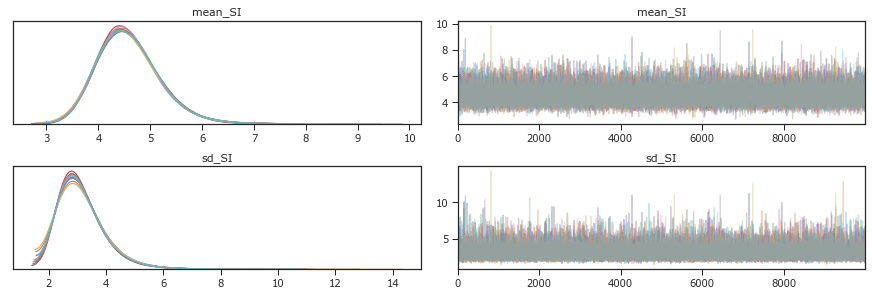

In [7]:
folder = "lognormal-no_truncation"
distrib, truncation_type = folder.split("-")

print(colored(folder, 'red'))
posterior_glob = !cd "{resultsdir}/{folder}"; ls trace-*
cmdstan_data = az.from_cmdstan(posterior = [resultsdir+"/"+folder+"/"+x for x in posterior_glob], 
                               log_likelihood="log_likelihood")
cmdstan_stats = get_stats(cmdstan_data.posterior.drop(['s_raw','e_raw','logmean_SI','logsd_SI','s','e']))

az.plot_trace(cmdstan_data, var_names=['mean_SI','sd_SI']);
plt.savefig(traceplotsdir+"/trace-"+folder+".pdf", format='pdf')
az.summary(cmdstan_data,credible_interval=0.95,var_names=['mean_SI','sd_SI','param1','param2'])

Correlation matrix
[[ 1.         -0.17581523]
 [-0.17581523  1.        ]]
Covariance matrix
[[ 0.01454363 -0.00187392]
 [-0.00187392  0.00781116]]
Precision matrix
[[ 70.95182707  17.02153838]
 [ 17.02153838 132.10554698]]


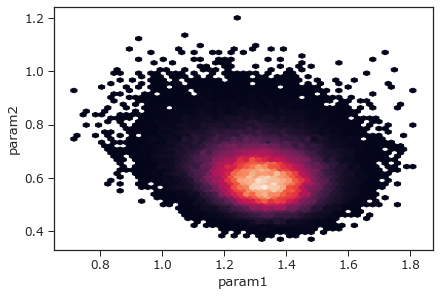

In [8]:
# correlation between param1 and param2
az.plot_pair(cmdstan_data, var_names = ['param1', 'param2'], kind='hexbin');

param1 = cmdstan_data.posterior.param1.values.ravel()
param2 = cmdstan_data.posterior.param2.values.ravel()
print(colored("Correlation matrix","blue"))
print(np.corrcoef(np.array([param1,param2])))
print(colored("Covariance matrix","blue"))
print(np.cov(np.array([param1,param2])))
print(colored("Precision matrix","blue"))
print(np.linalg.inv(np.cov(np.array([param1,param2]))))

gamma-no_truncation


,mean,sd,hpd_2.5%,hpd_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean_SI,4.769,0.577,3.688,5.927,0.002,0.001,111618.0,102462.0,123885.0,73018.0,1.0
sd_SI,2.939,0.585,1.963,4.125,0.002,0.001,92820.0,79387.0,118904.0,67033.0,1.0
param1,2.802,0.789,1.390,4.386,0.002,0.002,115448.0,115448.0,109237.0,78621.0,1.0
param2,0.596,0.182,0.271,0.963,0.001,0.000,121027.0,121027.0,111347.0,74008.0,1.0


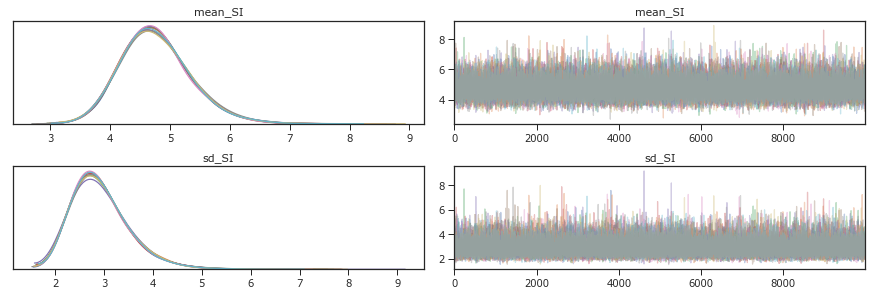

In [9]:
folder = "gamma-no_truncation"
distrib, truncation_type = folder.split("-")

print(colored(folder, 'red'))
posterior_glob = !cd "{resultsdir}/{folder}"; ls trace-*
cmdstan_data = az.from_cmdstan(posterior = [resultsdir+"/"+folder+"/"+x for x in posterior_glob], 
                               log_likelihood="log_likelihood")
cmdstan_stats = get_stats(cmdstan_data.posterior.drop(['e_raw','s_raw','e','s']))   

az.plot_trace(cmdstan_data, var_names = ['mean_SI','sd_SI']);
plt.savefig(traceplotsdir+"/trace-"+folder+".pdf", format='pdf')
az.summary(cmdstan_data, credible_interval=0.95, var_names = ['mean_SI','sd_SI','param1','param2'])

Correlation matrix
[[1.        0.9278559]
 [0.9278559 1.       ]]
Covariance matrix
[[0.62297071 0.1336203 ]
 [0.1336203  0.03329018]]
Precision matrix
[[ 11.54136061 -46.32476973]
 [-46.32476973 215.97747322]]


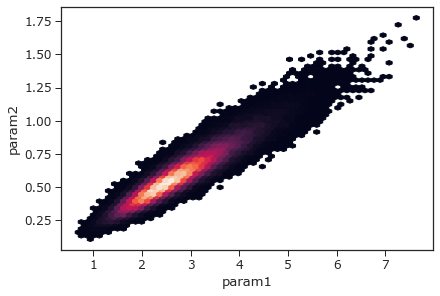

In [10]:
# correlation between param1 and param2
az.plot_pair(cmdstan_data, var_names = ['param1', 'param2'], kind='hexbin');

param1 = cmdstan_data.posterior.param1.values.ravel()
param2 = cmdstan_data.posterior.param2.values.ravel()
print(colored("Correlation matrix","blue"))
print(np.corrcoef(np.array([param1,param2])))
print(colored("Covariance matrix","blue"))
print(np.cov(np.array([param1,param2])))
print(colored("Precision matrix","blue"))
print(np.linalg.inv(np.cov(np.array([param1,param2]))))

weibull-no_truncation


,mean,sd,hpd_2.5%,hpd_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean_SI,4.751,0.532,3.744,5.816,0.001,0.001,174662.0,160208.0,184224.0,76276.0,1.0
sd_SI,2.720,0.473,1.951,3.659,0.001,0.001,115962.0,93039.0,179386.0,67329.0,1.0
param1,1.847,0.286,1.305,2.418,0.001,0.000,177295.0,175238.0,173907.0,78859.0,1.0
param2,5.325,0.603,4.160,6.521,0.001,0.001,184217.0,172698.0,188727.0,76874.0,1.0


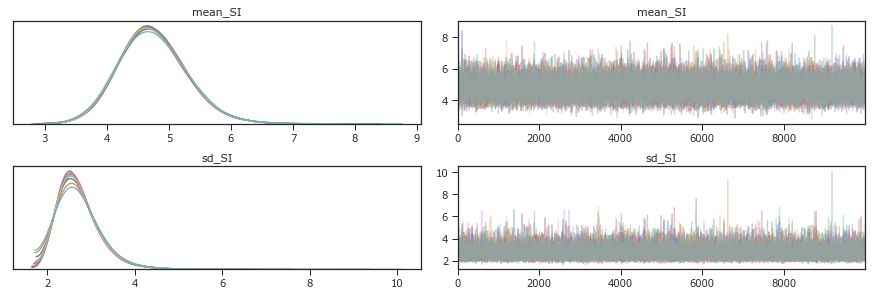

In [11]:
folder = "weibull-no_truncation"
distrib, truncation_type = folder.split("-")

print(colored(folder, 'red'))
posterior_glob = !cd "{resultsdir}/{folder}"; ls trace-*
cmdstan_data = az.from_cmdstan(posterior = [resultsdir+"/"+folder+"/"+x for x in posterior_glob], 
                               log_likelihood="log_likelihood")
cmdstan_stats = get_stats(cmdstan_data.posterior.drop(['e_raw','s_raw','e','s']))  

az.plot_trace(cmdstan_data, var_names=['mean_SI','sd_SI']);
plt.savefig(traceplotsdir+"/trace-"+folder+".pdf", format='pdf')
az.summary(cmdstan_data, credible_interval=0.95, var_names=['mean_SI','sd_SI','param1','param2'])

Correlation matrix
[[1.        0.2573314]
 [0.2573314 1.       ]]
Covariance matrix
[[0.08152238 0.04428136]
 [0.04428136 0.3632281 ]]
Precision matrix
[[13.13645891 -1.60147366]
 [-1.60147366  2.94832756]]


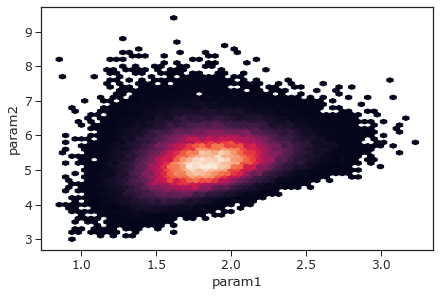

In [12]:
# correlation between param1 and param2
az.plot_pair(cmdstan_data, var_names = ['param1', 'param2'], kind='hexbin');

param1 = cmdstan_data.posterior.param1.values.ravel()
param2 = cmdstan_data.posterior.param2.values.ravel()
print(colored("Correlation matrix","blue"))
print(np.corrcoef(np.array([param1,param2])))
print(colored("Covariance matrix","blue"))
print(np.cov(np.array([param1,param2])))
print(colored("Precision matrix","blue"))
print(np.linalg.inv(np.cov(np.array([param1,param2]))))

## Comparing different models

In [13]:
for truncation_type in ['no_truncation']:
    for idx, distrib in enumerate(distribs):
        folder = distrib+"-"+truncation_type
        print(colored(folder, 'red'))
        posterior_glob = !cd "{resultsdir}/{folder}"; ls trace-*
        cmdstan_data = az.from_cmdstan(posterior = [resultsdir+"/"+folder+"/"+x for x in posterior_glob], 
                                       log_likelihood="log_likelihood")
        param1 = cmdstan_data.posterior.param1.values.ravel()
        param2 = cmdstan_data.posterior.param2.values.ravel()
        df_params12 = pd.DataFrame({'param1': param1, 'param2': param2})
        df_params12.to_pickle(tracesdir+'/'+folder+'.pickle')
        df_params12.round(5).to_csv(tracesdir+'/'+folder+'.csv', index=False)
        cmdstan_stats = get_stats(cmdstan_data.posterior.drop(['e_raw','s_raw','e','s'])) 

        df_ = cmdstan_stats
        meanSI_ = df_.loc[lambda d: d['var']=='mean_SI',['mean','q2.5','q97.5']].values[0]
        sdSI_ = df_.loc[lambda d: d['var']=='sd_SI',['mean','q2.5','q97.5']].values[0]

        if distrib=='gamma':
            # see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html
            y = np.percentile(np.stack([ss.gamma(param1[idx],scale=1/param2[idx]).ppf([.05,.5,.95,.99]).tolist() for idx in range(10000)]).T,[50,2.5,97.5],axis=1)
        elif distrib=='weibull':
            # see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.weibull_min.html
            y = np.percentile(np.stack([ss.weibull_min(param1[idx],scale=param2[idx]).ppf([.05,.5,.95,.99]).tolist() for idx in range(10000)]).T,[50,2.5,97.5],axis=1)
        elif distrib=='lognormal':
            # see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.lognorm.html
            y = np.percentile(np.stack([ss.lognorm(param2[idx],scale=np.exp(param1[idx])).ppf([.05,.5,.95,.99]).tolist() for idx in range(10000)]).T,[50,2.5,97.5],axis=1)
        output_ = [distrib,truncation_type,
              '%.1f (%.1f, %.1f)'%(meanSI_[0],meanSI_[1],meanSI_[2]),
              '%.1f (%.1f, %.1f)'%(sdSI_[0],sdSI_[1],sdSI_[2]),
              '%.1f (%.1f, %.1f)'%(y[:,0][0],y[:,0][1],y[:,0][2]),
              '%.1f (%.1f, %.1f)'%(y[:,1][0],y[:,1][1],y[:,1][2]), 
              '%.1f (%.1f, %.1f)'%(y[:,2][0],y[:,2][1],y[:,2][2]), 
              '%.1f (%.1f, %.1f)'%(y[:,3][0],y[:,3][1],y[:,3][2])]

        output = [output_] if idx==0 else np.r_[output, [output_]]
        print(output_)
        cmdstan_data_all = [cmdstan_data] if idx==0 else np.r_[cmdstan_data_all, cmdstan_data]


    output_df = pd.DataFrame(output,
                             columns=['Distribution', 'Truncation', 'mean', 
                                      'SD', 'q5', 'median', 'q95', 'q99'])

    models = dict([[distribs[idx], cmdstan_data_all[idx]] for idx in range(len(output))])
    stats_compare = az.compare(models, method='stacking', ic='waic', scale='deviance')

    df_stats_compare = stats_compare.reset_index().rename(columns={'index': 'Distribution'})
    df_stats_compare = df_stats_compare.loc[:,['Distribution','waic','d_waic','weight']]

    Df_ = df_stats_compare.merge(output_df)
    Df_['waic'] = [round(x,1) for x in Df_['waic']]
    Df_['d_waic'] = [round(x,2) for x in Df_['d_waic']]
    Df_['weight'] = [round(x,3) for x in Df_['weight']]
    display(Df_)

Df_.to_excel('../../results/Andrei/Stan-sims/summary-certain_and_probable-'+truncation_type+'.xlsx')

gamma-no_truncation
['gamma', 'no_truncation', '4.8 (3.8, 6.0)', '2.9 (2.1, 4.3)', '1.2 (0.5, 1.8)', '4.2 (3.2, 5.2)', '10.2 (8.0, 14.2)', '13.7 (10.4, 20.1)']
lognormal-no_truncation
['lognormal', 'no_truncation', '4.6 (3.6, 5.9)', '3.2 (2.0, 5.2)', '1.4 (0.9, 1.9)', '3.8 (2.9, 4.7)', '10.2 (7.7, 15.3)', '15.4 (10.9, 26.0)']
weibull-no_truncation
['weibull', 'no_truncation', '4.8 (3.8, 5.9)', '2.7 (2.0, 3.9)', '1.1 (0.5, 1.7)', '4.3 (3.3, 5.5)', '9.6 (7.9, 13.0)', '12.1 (9.7, 17.6)']


,Distribution,waic,d_waic,weight,Truncation,mean,SD,q5,median,q95,q99
0,weibull,133.0,0.00,0.358,no_truncation,"4.8 (3.8, 5.9)","2.7 (2.0, 3.9)","1.1 (0.5, 1.7)","4.3 (3.3, 5.5)","9.6 (7.9, 13.0)","12.1 (9.7, 17.6)"
1,gamma,133.1,0.10,0.333,no_truncation,"4.8 (3.8, 6.0)","2.9 (2.1, 4.3)","1.2 (0.5, 1.8)","4.2 (3.2, 5.2)","10.2 (8.0, 14.2)","13.7 (10.4, 20.1)"
2,lognormal,133.9,0.95,0.308,no_truncation,"4.6 (3.6, 5.9)","3.2 (2.0, 5.2)","1.4 (0.9, 1.9)","3.8 (2.9, 4.7)","10.2 (7.7, 15.3)","15.4 (10.9, 26.0)"


# With truncation

lognormal-truncated


,mean,sd,hpd_2.5%,hpd_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean_SI,4.773,0.706,3.548,6.190,0.002,0.002,88645.0,74186.0,119928.0,62298.0,1.0
sd_SI,3.455,1.092,1.876,5.545,0.004,0.003,69285.0,52991.0,115024.0,58987.0,1.0
param1,1.345,0.128,1.095,1.603,0.000,0.000,113513.0,112359.0,114399.0,80443.0,1.0
param2,0.637,0.098,0.462,0.836,0.000,0.000,88413.0,81030.0,99883.0,70581.0,1.0


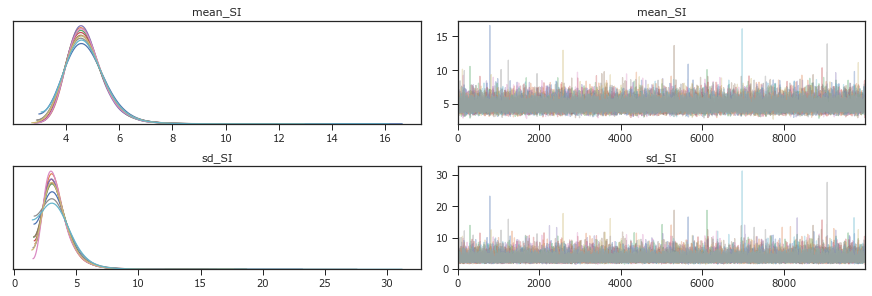

In [14]:
folder = "lognormal-truncated"
distrib, truncation_type = folder.split("-")

print(colored(folder, 'red'))
posterior_glob = !cd "{resultsdir}/{folder}"; ls trace-*
cmdstan_data = az.from_cmdstan(posterior = [resultsdir+"/"+folder+"/"+x for x in posterior_glob], 
                               log_likelihood="log_likelihood")
cmdstan_stats = get_stats(cmdstan_data.posterior.drop(['e_raw','s_raw','e','s']))  

az.plot_trace(cmdstan_data, var_names=['mean_SI','sd_SI']);
plt.savefig(traceplotsdir+"/trace-"+folder+".pdf", format='pdf')
az.summary(cmdstan_data,credible_interval=0.95,var_names=['mean_SI','sd_SI','param1','param2'])

Correlation matrix
[[ 1.         -0.05332787]
 [-0.05332787  1.        ]]
Covariance matrix
[[ 0.01638179 -0.00067051]
 [-0.00067051  0.00965038]]
Precision matrix
[[ 61.21749163   4.25341988]
 [  4.25341988 103.91840348]]


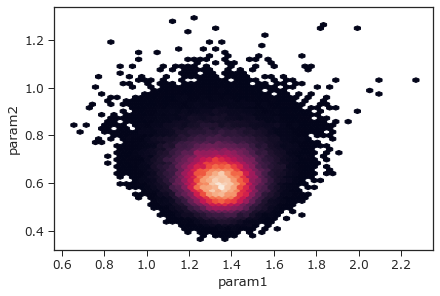

In [15]:
# correlation between param1 and param2
az.plot_pair(cmdstan_data, var_names = ['param1', 'param2'], kind='hexbin');

param1 = cmdstan_data.posterior.param1.values.ravel()
param2 = cmdstan_data.posterior.param2.values.ravel()
print(colored("Correlation matrix","blue"))
print(np.corrcoef(np.array([param1,param2])))
print(colored("Covariance matrix","blue"))
print(np.cov(np.array([param1,param2])))
print(colored("Precision matrix","blue"))
print(np.linalg.inv(np.cov(np.array([param1,param2]))))

gamma-truncated


,mean,sd,hpd_2.5%,hpd_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean_SI,4.940,0.705,3.697,6.320,0.002,0.002,79934.0,62697.0,112589.0,59814.0,1.0
sd_SI,3.132,0.773,1.959,4.629,0.003,0.003,65978.0,46601.0,107034.0,56833.0,1.0
param1,2.687,0.794,1.243,4.260,0.002,0.002,104742.0,104742.0,97733.0,71288.0,1.0
param2,0.557,0.187,0.210,0.924,0.001,0.000,111165.0,111165.0,99647.0,63226.0,1.0


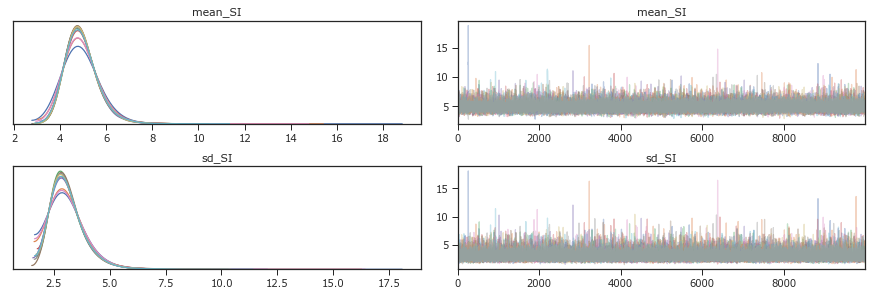

In [16]:
folder = "gamma-truncated"
distrib, truncation_type = folder.split("-")

print(colored(folder, 'red'))
posterior_glob = !cd "{resultsdir}/{folder}"; ls trace-*
cmdstan_data = az.from_cmdstan(posterior = [resultsdir+"/"+folder+"/"+x for x in posterior_glob], 
                               log_likelihood="log_likelihood")
cmdstan_stats = get_stats(cmdstan_data.posterior.drop(['e_raw','s_raw','e','s']))  

az.plot_trace(cmdstan_data, var_names=['mean_SI','sd_SI']);
plt.savefig(traceplotsdir+"/trace-"+folder+".pdf", format='pdf')
az.summary(cmdstan_data,credible_interval=0.95,var_names=['mean_SI','sd_SI','param1','param2'])

Correlation matrix
[[1.        0.9302737]
 [0.9302737 1.       ]]
Covariance matrix
[[0.63054295 0.13826483]
 [0.13826483 0.0350338 ]]
Precision matrix
[[ 11.78337857 -46.50442397]
 [-46.50442397 212.07878135]]


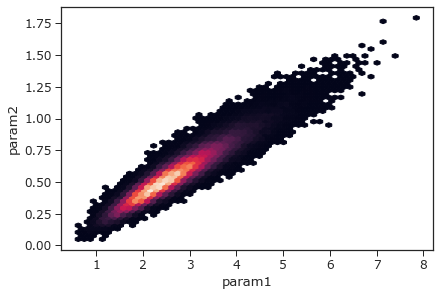

In [17]:
# correlation between param1 and param2
az.plot_pair(cmdstan_data, var_names = ['param1', 'param2'], kind='hexbin');

param1 = cmdstan_data.posterior.param1.values.ravel()
param2 = cmdstan_data.posterior.param2.values.ravel()
print(colored("Correlation matrix","blue"))
print(np.corrcoef(np.array([param1,param2])))
print(colored("Covariance matrix","blue"))
print(np.cov(np.array([param1,param2])))
print(colored("Precision matrix","blue"))
print(np.linalg.inv(np.cov(np.array([param1,param2]))))

weibull-truncated


,mean,sd,hpd_2.5%,hpd_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean_SI,4.858,0.619,3.742,6.051,0.002,0.002,98758.0,76123.0,136397.0,62502.0,1.0
sd_SI,2.834,0.644,1.932,3.986,0.003,0.002,63674.0,49012.0,130691.0,56677.0,1.0
param1,1.823,0.300,1.253,2.428,0.001,0.001,132277.0,132277.0,128958.0,69004.0,1.0
param2,5.435,0.678,4.156,6.753,0.002,0.002,116860.0,96434.0,143527.0,67381.0,1.0


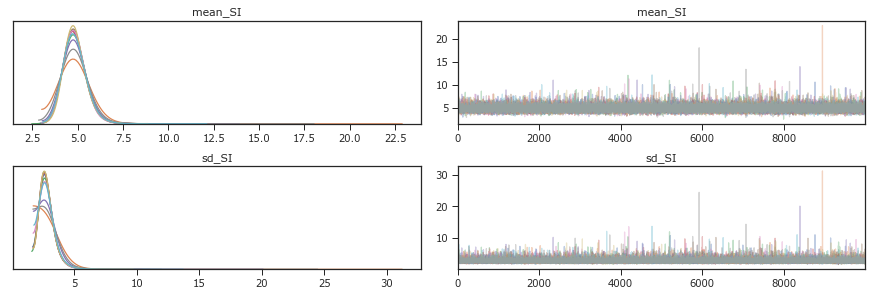

In [18]:
folder = "weibull-truncated"
distrib, truncation_type = folder.split("-")

print(colored(folder, 'red'))
posterior_glob = !cd "{resultsdir}/{folder}"; ls trace-*
cmdstan_data = az.from_cmdstan(posterior = [resultsdir+"/"+folder+"/"+x for x in posterior_glob], 
                               log_likelihood="log_likelihood")
cmdstan_stats = get_stats(cmdstan_data.posterior.drop(['e_raw','s_raw','e','s']))  

az.plot_trace(cmdstan_data, var_names=['mean_SI','sd_SI']);
plt.savefig(traceplotsdir+"/trace-"+folder+".pdf", format='pdf')
az.summary(cmdstan_data,credible_interval=0.95,var_names=['mean_SI','sd_SI','param1','param2'])

Correlation matrix
[[1.        0.1138092]
 [0.1138092 1.       ]]
Covariance matrix
[[0.08971994 0.02310163]
 [0.02310163 0.45924176]]
Precision matrix
[[11.29205496 -0.56803376]
 [-0.56803376  2.20607661]]


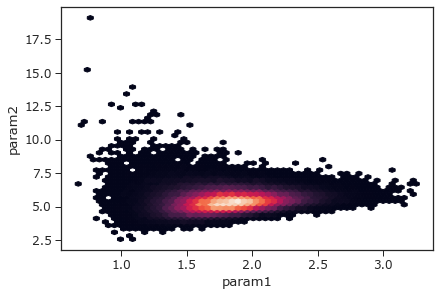

In [19]:
# correlation between param1 and param2
az.plot_pair(cmdstan_data, var_names = ['param1', 'param2'], kind='hexbin');

param1 = cmdstan_data.posterior.param1.values.ravel()
param2 = cmdstan_data.posterior.param2.values.ravel()
print(colored("Correlation matrix","blue"))
print(np.corrcoef(np.array([param1,param2])))
print(colored("Covariance matrix","blue"))
print(np.cov(np.array([param1,param2])))
print(colored("Precision matrix","blue"))
print(np.linalg.inv(np.cov(np.array([param1,param2]))))

In [20]:
for truncation_type in ['truncated']:
    for idx, distrib in enumerate(distribs):
        folder = distrib+"-"+truncation_type
        
        print(colored(folder, 'red'))
        posterior_glob = !cd "{resultsdir}/{folder}"; ls trace-*
        cmdstan_data = az.from_cmdstan(posterior = [resultsdir+"/"+folder+"/"+x for x in posterior_glob], 
                                       log_likelihood="log_likelihood")
        param1 = cmdstan_data.posterior.param1.values.ravel()
        param2 = cmdstan_data.posterior.param2.values.ravel()
        df_params12 = pd.DataFrame({'param1': param1, 'param2': param2})
        df_params12.to_pickle(tracesdir+'/'+folder+'.pickle')
        df_params12.round(5).to_csv(tracesdir+'/'+folder+'.csv', index=False)
        cmdstan_stats = get_stats(cmdstan_data.posterior.drop(['e_raw','s_raw','e','s']))  

        df_ = cmdstan_stats
        meanSI_ = df_.loc[lambda d: d['var']=='mean_SI',['mean','q2.5','q97.5']].values[0]
        sdSI_ = df_.loc[lambda d: d['var']=='sd_SI',['mean','q2.5','q97.5']].values[0]

        if distrib=='gamma':
            # see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html
            y = np.percentile(np.stack([ss.gamma(param1[idx],scale=1/param2[idx]).ppf([.05,.5,.95,.99]).tolist() for idx in range(10000)]).T,[50,2.5,97.5],axis=1)
        elif distrib=='weibull':
            # see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.weibull_min.html
            y = np.percentile(np.stack([ss.weibull_min(param1[idx],scale=param2[idx]).ppf([.05,.5,.95,.99]).tolist() for idx in range(10000)]).T,[50,2.5,97.5],axis=1)
        elif distrib=='lognormal':
            # see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.lognorm.html
            y = np.percentile(np.stack([ss.lognorm(param2[idx],scale=np.exp(param1[idx])).ppf([.05,.5,.95,.99]).tolist() for idx in range(10000)]).T,[50,2.5,97.5],axis=1)
        output_ = [distrib,truncation_type,
              '%.1f (%.1f, %.1f)'%(meanSI_[0],meanSI_[1],meanSI_[2]),
              '%.1f (%.1f, %.1f)'%(sdSI_[0],sdSI_[1],sdSI_[2]),
              '%.1f (%.1f, %.1f)'%(y[:,0][0],y[:,0][1],y[:,0][2]),
              '%.1f (%.1f, %.1f)'%(y[:,1][0],y[:,1][1],y[:,1][2]), 
              '%.1f (%.1f, %.1f)'%(y[:,2][0],y[:,2][1],y[:,2][2]), 
              '%.1f (%.1f, %.1f)'%(y[:,3][0],y[:,3][1],y[:,3][2])]

        output = [output_] if idx==0 else np.r_[output, [output_]]
        print(output_)
        cmdstan_data_all = [cmdstan_data] if idx==0 else np.r_[cmdstan_data_all, cmdstan_data]

    output_df = pd.DataFrame(output,
                             columns=['Distribution', 'Truncation', 'mean', 
                                      'SD', 'q5', 'median', 'q95', 'q99'])

    models = dict([[distribs[idx], cmdstan_data_all[idx]] for idx in range(len(output))])
    stats_compare = az.compare(models, method='stacking', ic='waic', scale='deviance')

    df_stats_compare = stats_compare.reset_index().rename(columns={'index': 'Distribution'})
    df_stats_compare = df_stats_compare.loc[:,['Distribution','waic','d_waic','weight']]

    Df_ = df_stats_compare.merge(output_df)
    Df_['waic'] = [round(x,1) for x in Df_['waic']]
    Df_['d_waic'] = [round(x,2) for x in Df_['d_waic']]
    Df_['weight'] = [round(x,3) for x in Df_['weight']]
    display(Df_)

Df_.to_excel('../../results/Andrei/Stan-sims/summary-certain_and_probable-'+truncation_type+'.xlsx')

gamma-truncated
['gamma', 'truncated', '4.9 (3.8, 6.5)', '3.1 (2.1, 5.0)', '1.2 (0.5, 1.8)', '4.2 (3.3, 5.5)', '10.6 (8.1, 16.0)', '14.3 (10.6, 23.1)']
lognormal-truncated
['lognormal', 'truncated', '4.8 (3.7, 6.4)', '3.5 (2.1, 6.2)', '1.4 (0.9, 1.9)', '3.8 (3.0, 4.9)', '10.7 (7.9, 17.1)', '16.5 (11.1, 30.2)']
weibull-truncated
['weibull', 'truncated', '4.9 (3.8, 6.2)', '2.8 (2.1, 4.3)', '1.0 (0.5, 1.7)', '4.4 (3.3, 5.6)', '9.8 (7.8, 14.3)', '12.4 (9.7, 19.8)']


,Distribution,waic,d_waic,weight,Truncation,mean,SD,q5,median,q95,q99
0,weibull,229.4,0.00,0.287,truncated,"4.9 (3.8, 6.2)","2.8 (2.1, 4.3)","1.0 (0.5, 1.7)","4.4 (3.3, 5.6)","9.8 (7.8, 14.3)","12.4 (9.7, 19.8)"
1,gamma,229.5,0.09,0.333,truncated,"4.9 (3.8, 6.5)","3.1 (2.1, 5.0)","1.2 (0.5, 1.8)","4.2 (3.3, 5.5)","10.6 (8.1, 16.0)","14.3 (10.6, 23.1)"
2,lognormal,229.8,0.37,0.379,truncated,"4.8 (3.7, 6.4)","3.5 (2.1, 6.2)","1.4 (0.9, 1.9)","3.8 (3.0, 4.9)","10.7 (7.9, 17.1)","16.5 (11.1, 30.2)"
